## Finding out Keas sex with FastAI
Using: https://towardsdatascience.com/fastai-image-classification-32d626da20

You can visually tell different kea apart, and approximate what their life stage and sex might be.

**Definitions:** crown (top of head), ceres (base of bill), plumage (feathers)

### Life stage
**Fledgling (this year’s chick):** pale yellow crown; pale yellow ceres & eyelids; immaculate plumage (no sign of moulting)

**Juvenile (previous year’s chick):** less pale yellow crown; rich yellow ceres & eyelids; many worn feathers (may be moulting)

**Sub-adult (2–4 years old):** dark crown; splotchy mix of yellow/black ceres & eyelids; generally tidy plumage (may be moulting)

**Adult (4 years plus):** dark crown; mostly dark ceres & eyelids; generally tidy plumage (may be moulting)

![Female / Male](https://keadatabase.files.wordpress.com/2017/08/lifestages2.jpg)
(Fledgling, Juvenile, Sub-Adult)

### Sex
**Female:** Generally smaller than male kea. Skull length (59–67 mm) and bill length (39–50 mm) generally shorter than males. Similar length of upper and lower bill.

**Male:** Larger than female kea. Skull length (64–70 mm) and bill length (47–55 mm) generally longer than females. Pronounced difference between length of upper and lower bill.

![Female / Male](https://keadatabase.files.wordpress.com/2017/08/femalemale.jpg)
(Female/Male)

In [10]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
from fastai.imports import *
from fastai.vision import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Set up training data
Set up training data and output classes

In [11]:
np.random.seed(42)
path = Path('images')
data = ImageDataBunch.from_folder(path, train='.', valid_pct=0.2,
                                  ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)
data.classes

['female', 'male']

## Show images with classes

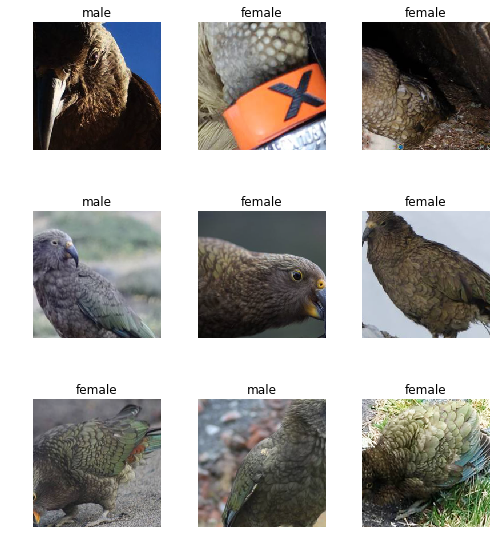

In [12]:
data.show_batch(rows=3, figsize=(7, 8))

## Creating a model and initial training

In [37]:
from fastai.metrics import error_rate # 1 - accuracy

learn = cnn_learner(data, models.resnet34, metrics=error_rate)
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.242848,2.037611,0.678161,03:30
1,1.059901,0.887632,0.402299,03:14
2,0.893431,0.698070,0.333333,03:44
3,0.764666,0.613224,0.252874,02:59


## Find the perfect learning rate

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


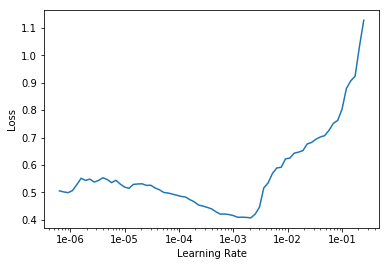

In [38]:
learn.unfreeze() # must be done before calling lr_find
learn.lr_find()
learn.recorder.plot()

In [41]:
# To now train the model using differential 
# learning rates we need to pass the max_lr argument to the fit_one_cycle method.
learn.fit_one_cycle(4, max_lr=slice(3e-5, 3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.487092,0.536366,0.218391,06:18
1,0.409673,0.496081,0.172414,07:13
2,0.393730,0.362906,0.172414,04:20
3,0.349625,0.310361,0.149425,06:05


In [42]:
learn.save('kea-detection-stage-1')

## Cleaning data

In [43]:
from fastai.widgets import *

ds, idxs = DatasetFormatter().from_toplosses(learn)
ImageCleaner(ds, idxs, path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

## Final training

In [44]:
df = pd.read_csv(path/'cleaned.csv', header='infer')
print(df.head())

db = (ImageList.from_df(df, path)
                   .split_by_rand_pct(0.2)
                   .label_from_df()
                   .transform(get_transforms(), size=224)
                   .databunch(bs=8)).normalize(imagenet_stats)

                                                name label
0  valid/male/Wyn_Aoraki-crop-c0-67__0-56-350x250...  male
1  valid/male/Whakatoi-crop-c0-36__0-51-350x250-7...  male
2      valid/male/You-crop-c0-5__0-5-350x250-70.jpeg  male
3  valid/male/WhiteEonBrown-crop-c0-37__0-24-350x...  male
4  valid/male/Three_kea_Wei_Chean-crop-c0-6__0-55...  male


We can now print out the lengths of both the new and old dataset to see how many images we deleted.

In [45]:
print(data.classes, data.c, len(data.train_ds), len(data.valid_ds))
print(db.classes, db.c, len(db.train_ds), len(db.valid_ds))

['female', 'male'] 2 349 87
['female', 'male'] 2 280 69


## Show random batch

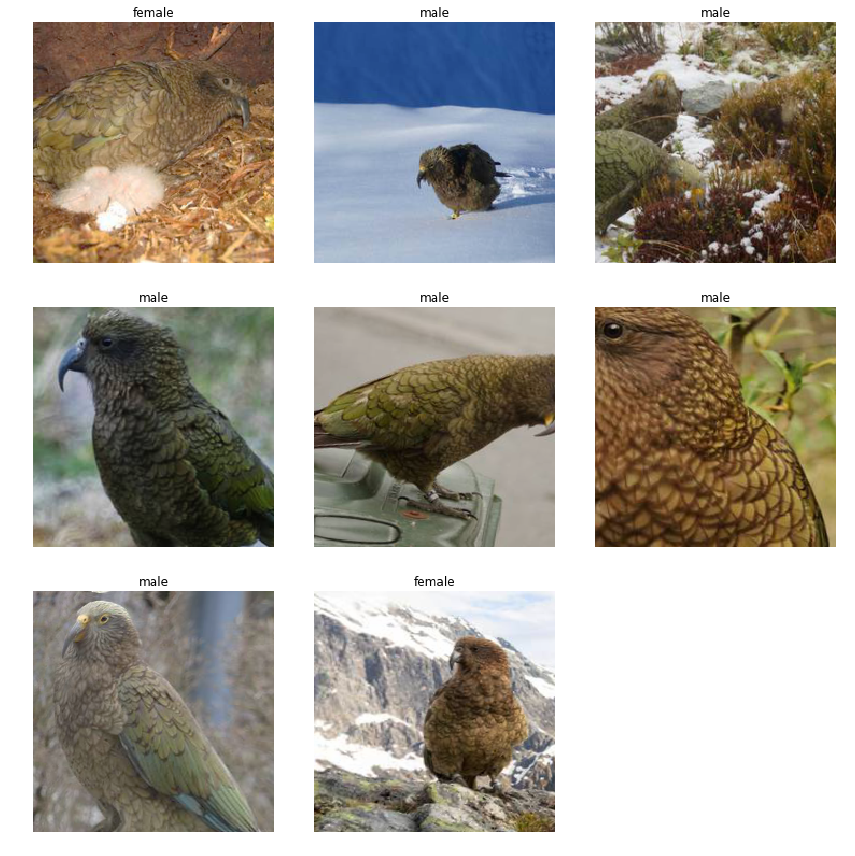

In [46]:
db.show_batch()

Now we can apply the same training steps as above but using the new data. We are also going to use the saved weights so we don’t need to start from scratch.

epoch,train_loss,valid_loss,error_rate,time
0,0.508460,0.232146,0.115942,03:37
1,0.763958,0.160793,0.057971,02:02
2,0.574620,0.198684,0.086957,03:16
3,0.455166,0.167123,0.057971,03:13


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,error_rate,time
0,0.385079,0.284948,0.101449,02:59
1,0.406638,0.610519,0.231884,02:59
2,0.512351,0.236834,0.072464,02:57
3,0.393692,0.222505,0.086957,02:53


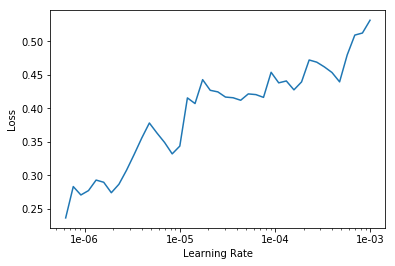

In [47]:
learn.load('kea-detection-stage-1') # loading the weights
learn.data = db # replacing the data

learn.freeze()
learn.fit_one_cycle(4)

learn.unfreeze()

learn.lr_find()
learn.recorder.plot()

learn.fit_one_cycle(4, max_lr=slice(3e-5, 3e-4))
learn.save('keas-detection-stage-2')

## Interpretation
Lastly, we can use FastAIs ClassificationInterpretation class to interpret our results. To create an interpretation object we need to call the from_learner method and pass it our learner/model. Then we can use methods like plot_confusion_matrix, plot_top_losses or most_confused.

In [31]:
interp = ClassificationInterpretation.from_learner(learn)

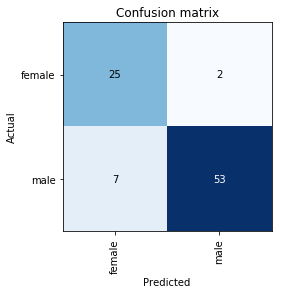

In [32]:
interp.plot_confusion_matrix()

## Plot top losses

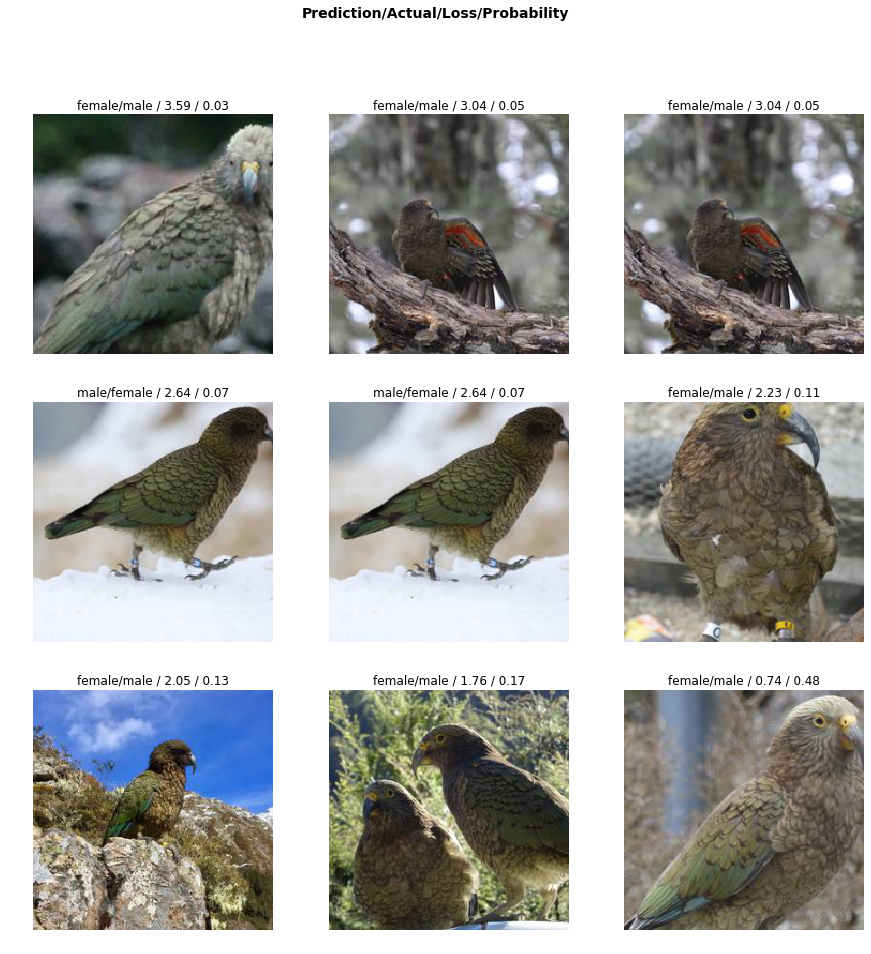

In [33]:
interp.plot_top_losses(9, figsize=(15,15))

## Conclusion